# Generating lightcone noise samples - Comparing between `tuesday` and `tools21cm`
In this notebook, we compare lightcone noise generation methods from `tools21cm` (master branch on 01/07/25, commit c0cc4d5) with `tuesday`.
We do this using the `AA4` SKA layout. \
We start by importing key modules and defining a plotting function to compare outputs from the two.

In [1]:
import numpy as np
from py21cmsense import Observatory, Observation
from py21cmsense.conversions import f2z
import astropy.units as un

from tools21cm.radio_telescope_noise import get_uv_map, get_SKA_Low_layout
import matplotlib.pyplot as plt

In [2]:
def compare(tools_qt, tuesday_qt, qt_name="", f = "150 MHz", vmin=None, vmax=None):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6), gridspec_kw={"width_ratios":[1,1,0.07]})
    if vmin is None:
        vmin = np.nanpercentile(tools_qt, 2.5)
    if vmax is None:
        vmax = np.nanpercentile(tools_qt, 97.5)
    axs[0].set_title(f"tuesday - {qt_name} at {f} for SKA AA4")
    axs[0].imshow(np.flip(tuesday_qt.T), origin="lower", vmin = vmin, vmax = vmax)
    axs[1].set_title(f"tools21cm - {qt_name} at {f} for SKA AA4")
    im=axs[1].imshow(tools_qt.T, origin="lower", vmin = vmin, vmax = vmax)
    fig.colorbar(im,  label = qt_name, cax = axs[2],fraction=0.1,shrink=0.6)
    plt.show()
    err = tools_qt.T - np.flip(tuesday_qt.T)
    vmin = np.nanpercentile(err, 2.5)
    vmax = np.nanpercentile(err, 97.5)
    fig, axs = plt.subplots(1,2, figsize=(12, 6))
    im = axs[0].imshow(err, vmin = vmin, vmax = vmax, origin="lower")
    fig.colorbar(im,  label = f"tools21cm  {qt_name} - 21cmSense {qt_name}", fraction=0.1,shrink=0.8)
    axs[1].hist(err.ravel(), bins = np.linspace(vmin,vmax,20))
    axs[1].set_xlabel(f"tools21cm {qt_name} - 21cmSense {qt_name}")
    plt.show()

# Compare SKA AA4 layouts
We check that the station layouts used in both codes are the same:

In [3]:
hours_tracking = 6.*un.hour
observatory = Observatory.from_ska("AA4")
freqs = np.array([150.0, 250.0]) * un.MHz

In [4]:
enu_coords = get_SKA_Low_layout("AA4", unit="enu")

AA4 contains 512 antennae.


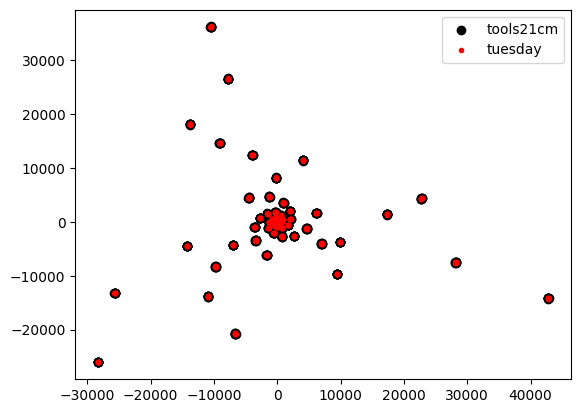

In [5]:
plt.scatter(enu_coords[:,0], enu_coords[:,1], color = "k", label = "tools21cm")
plt.scatter(observatory.antpos[:,0], observatory.antpos[:,1], color = "r", marker = ".", label = "tuesday")
plt.legend()
plt.show()

We confirm that both `tools21cm` and `21cmSense` are using the same SKA antenna layout.\
Next, we calculate the uv coverage with both codes.\
To do this, both codes assume that the lightcone is the field of view of the instrument.
# Calculating uv coverage with `tuesday`
With `tuesday`, the user  can use the `Observatory` object along with the integration time and daily observation duration to calculate the location of a reference point through zenith as the sky rotates overhead during the day. This will provide us with `daily observation duration in s / integration time in s` time offsets.

In [6]:
observatory = observatory.clone(beam=observatory.beam.clone(frequency=freqs[0]))
integration_time = 60*un.s
time_offsets = observatory.time_offsets_from_obs_int_time(integration_time, hours_tracking)

Once we have the time offsets, the last missing ingredient is to obtain the baseline groups of the instrument and the weights of each (i.e. how many baselines are in a given group):

In [7]:
baseline_groups = observatory.get_redundant_baselines()
baselines = observatory.baseline_coords_from_groups(baseline_groups)
print("We have", baselines.shape[0], "baseline groups.")
weights = observatory.baseline_weights_from_groups(baseline_groups)
bl_max = np.sqrt(np.max(np.sum(baselines**2, axis=1)))

finding redundancies: 100%|██████████| 511/511 [00:01<00:00, 471.79ants/s]


We have 261582 baseline groups.


In [8]:
from tuesday.core import grid_baselines_uv

Now that we have the baseline groups and the time offsets, we take the baseline groups and move them for each time offset as the sky rotates over the instrument:

In [9]:
proj_bls = observatory.projected_baselines(baselines=baselines, #21cmsense caches them 
                                           time_offset = time_offsets, ) #(Nbls, N time_offsets, 3)

Now we know how the baselines move at each snapshot (i.e. time offset). \
The next step is to grid these baselines by counting how many times each baseline pair is observed during the daily observation (i.e. over all of the time offsets).\
Since we want to sample noise on a lightcone, we need to choose our uv grid to match the size of the lightcone. \
In other words, we enforce the field of view of our observation to be the lightcone. \
To perform the gridding, we thus need to choose the parameters of our lightcone:\
Suppose we want to sample thermal noise on a 300 cMpc lightcone with 1.5 cMpc resolution.

In [10]:
lc_shape = np.array([200,200,1945])
boxlength = 300. *un.Mpc

We can grid the baselines now. Note that in this step we decimate the baseline and their weight arrays by two. This is because these array originally contain both the positive baselines $\textit{and}$ their mirrored copy i.e. (u,v) and (-u,-v) which do not contribute to reducing our SNR (since they're the same). The `grid_baselines_uv` assumes we provide only one copy of the baselines and is a little bit faster that way. We loop over the frequencies and rescale the baselines accordingly.

In [11]:
uv_coverage = np.zeros((lc_shape[0],lc_shape[0],len(freqs)))#Nu, Nv, Nfreqs
for i, freq in enumerate(freqs): 
    # uv coverage integrated over one field
    uv_coverage[...,i] += grid_baselines_uv(proj_bls[::2]*freq/freqs[0],
                              freq,
                        boxlength, 
                        lc_shape,
                        weights[::2])

# Calculate uv coverage with `tools21cm`

In [12]:
redshifts = [f2z(freq) for freq in freqs]
uv_tools = np.zeros_like(uv_coverage)
for i,z in enumerate(redshifts):
    uv, Nant = get_uv_map(lc_shape[0],z, 
                                 boxsize=boxlength.value,
                                 int_time=integration_time.value,
                                 total_int_time= hours_tracking.value,
                                 include_mirror_baselines=True,
                                 declination = -26.824722)
    uv_tools[...,i] = np.fft.fftshift(uv)*int(3600*hours_tracking.value/integration_time.value)

AA4 contains 512 antennae.
ENU -> ECEF -> XYZ
Generating uv map from daily observations...


Gridding uv tracks: 100%|██████████| 360/360 [00:05<00:00, 66.44it/s]


...done
AA4 contains 512 antennae.
ENU -> ECEF -> XYZ
Generating uv map from daily observations...


Gridding uv tracks: 100%|██████████| 360/360 [00:05<00:00, 71.95it/s]

...done


# Compare uv coverage

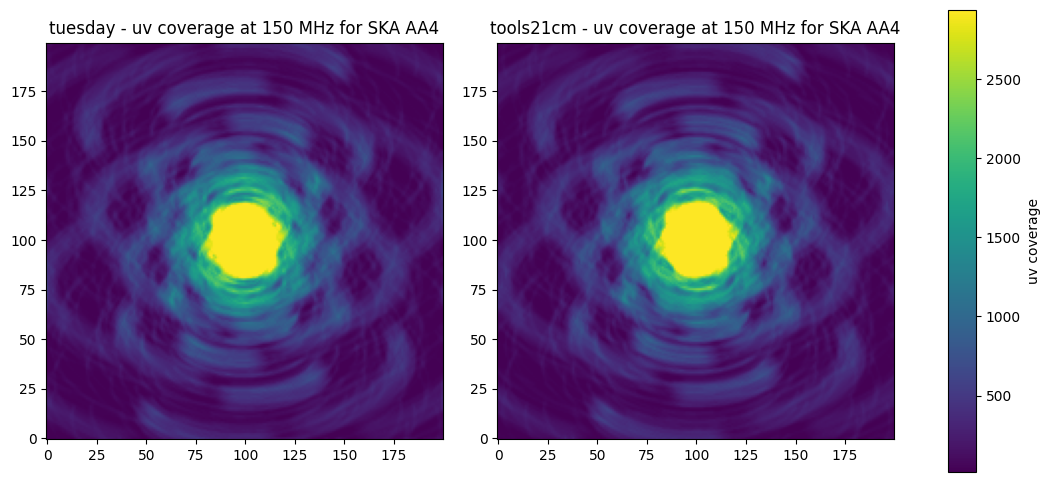

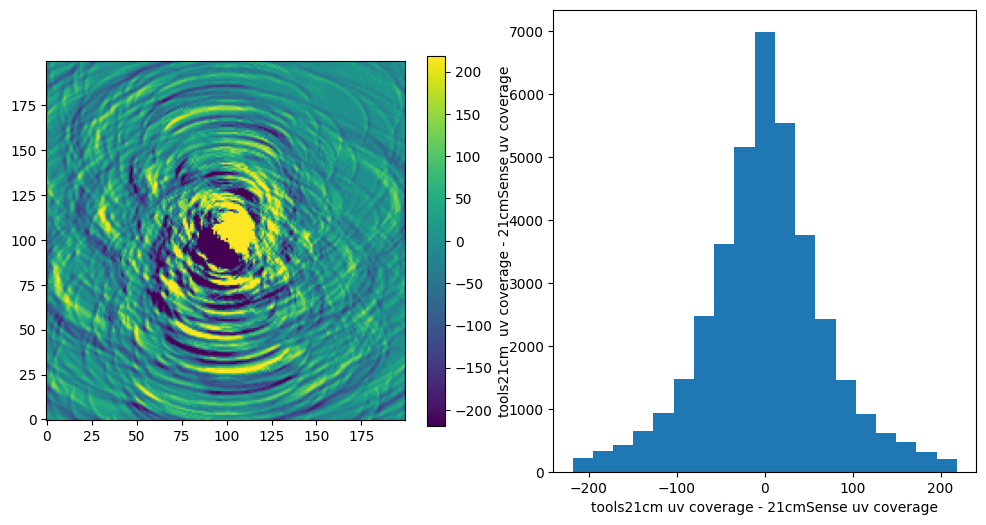

In [13]:
compare(uv_tools[...,0], uv_coverage[...,0], "uv coverage", f = "150 MHz")

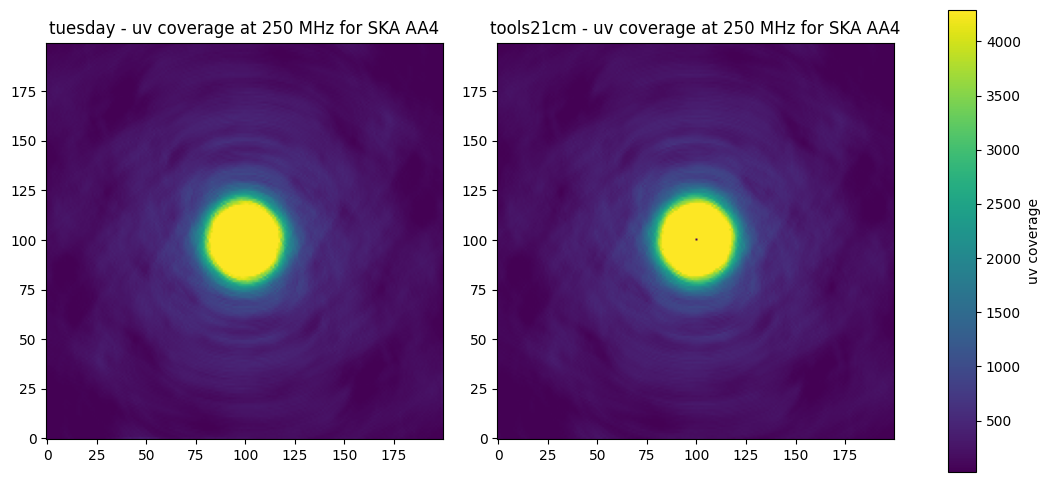

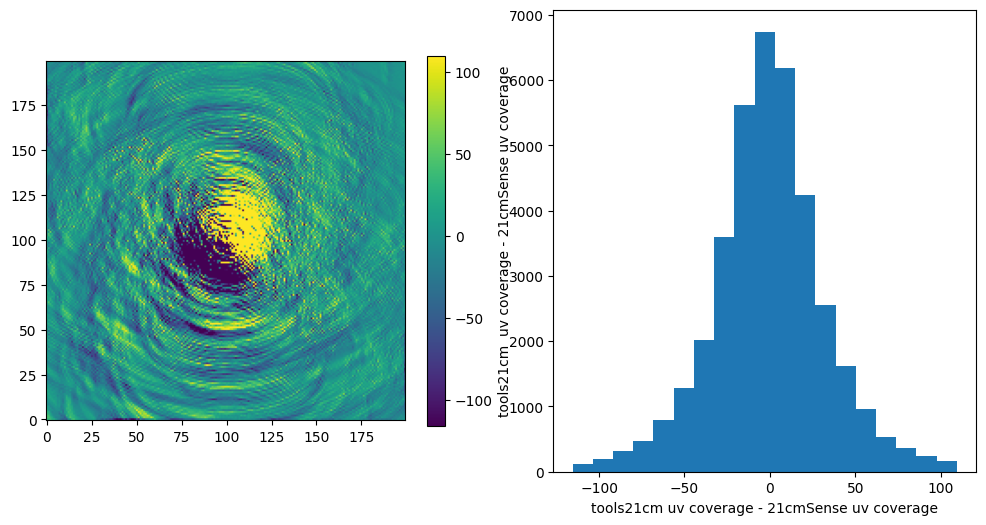

In [14]:
compare(uv_tools[...,1], uv_coverage[...,1], "uv coverage", f = "250 MHz")

# Calculate the thermal RMS noise with `tuesday`

To calculate the thermal noise with `tuesday`, we need to define an `Observation`. Note that we choose $T_{\rm sky}$ parameters to match those in `tools21cm`.

In [15]:
from tuesday.core import thermal_noise_per_voxel

In [16]:
# Define an observation
obs = Observation(observatory=observatory.clone(beam=observatory.beam.clone(frequency=freqs[0])), 
            time_per_day=hours_tracking,
            lst_bin_size=hours_tracking,
            integration_time=integration_time,
            bandwidth=50 *un.kHz,
            n_days=int(np.ceil(1000/hours_tracking.value)),
            tsky_amplitude=60.*un.K,      # to be consistent with tools21cm
            tsky_ref_freq=300.*un.MHz,
            spectral_index=2.55,
                 )

In [17]:
sigmaN_rms = thermal_noise_per_voxel(obs, freqs, boxlength, lc_shape, antenna_effective_area = [517.7, 186.4]*un.m**2) #A_eff set to match tools21cm
sigmaN = sigmaN_rms / np.sqrt(uv_coverage * obs.n_days)
sigmaN[uv_coverage == 0.] = 0.

# Calculate thermal RMS noise with tools21cm

In [18]:
from tools21cm.radio_telescope_sensitivity import sigma_noise_radio, jansky_2_kelvin, kelvin_2_jansky
from tools21cm.radio_telescope_noise import noise_map

In [19]:
sigmaN_tools = np.zeros((lc_shape[0],lc_shape[0],len(freqs)))#Nu, Nv, Nfreqs
sigmaN_rms_tools = np.zeros(len(freqs))

for i, freq in enumerate(freqs): 
    sigma, rms_noi = sigma_noise_radio(f2z(freq), 
                                       obs.bandwidth.to(un.MHz).value, 
                                       obs.n_days*obs.time_per_day.value, 
                                       integration_time.value, 
                                       uv_map=uv_tools, 
                                       N_ant=512) #μJy
    sigmaN_rms_tools[i] = jansky_2_kelvin(rms_noi*1e-6, f2z(freq), boxsize=boxlength.value, ncells=lc_shape[0])[0] #mK
    print("RMS tools21cm",sigmaN_rms_tools[i], "vs RMS tuesday", sigmaN_rms[i])
    sigmaN_tools[...,i] = sigmaN_rms_tools[i] / np.sqrt(uv_tools[...,i] * obs.n_days)
sigmaN_tools[uv_tools == 0.] = 0.


Expected: rms in image in µJy per beam for full = [11.08944821]
Effective baseline = [0.5803084] m
Calculated: rms in the visibility = [983444.49945772] µJy
RMS tools21cm 56.17219074438801 vs RMS tuesday 54.23851346114949 mK

Expected: rms in image in µJy per beam for full = [13.33978878]
Effective baseline = [0.69806823] m
Calculated: rms in the visibility = [1183011.2419225] µJy
RMS tools21cm 16.964242498442857 vs RMS tuesday 16.51463278087388 mK


# Compare the thermal RMS noise

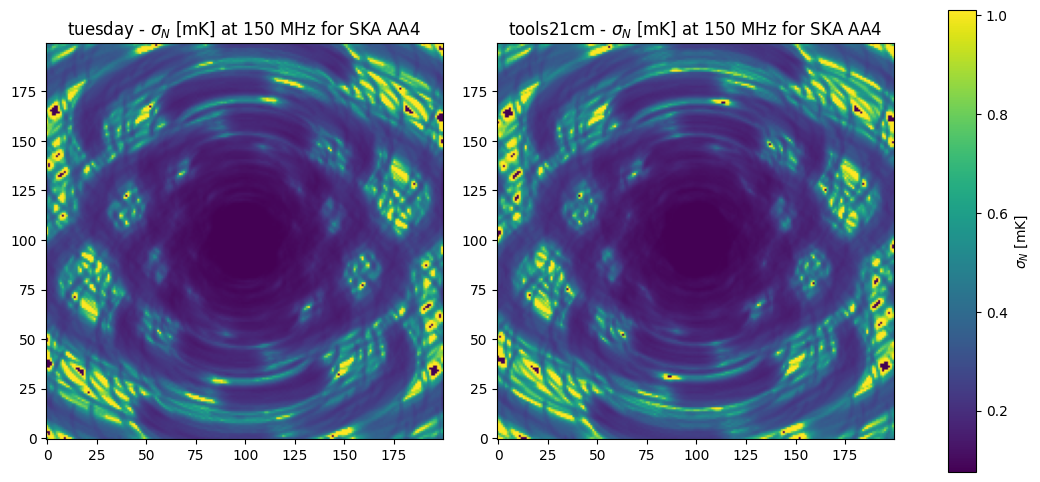

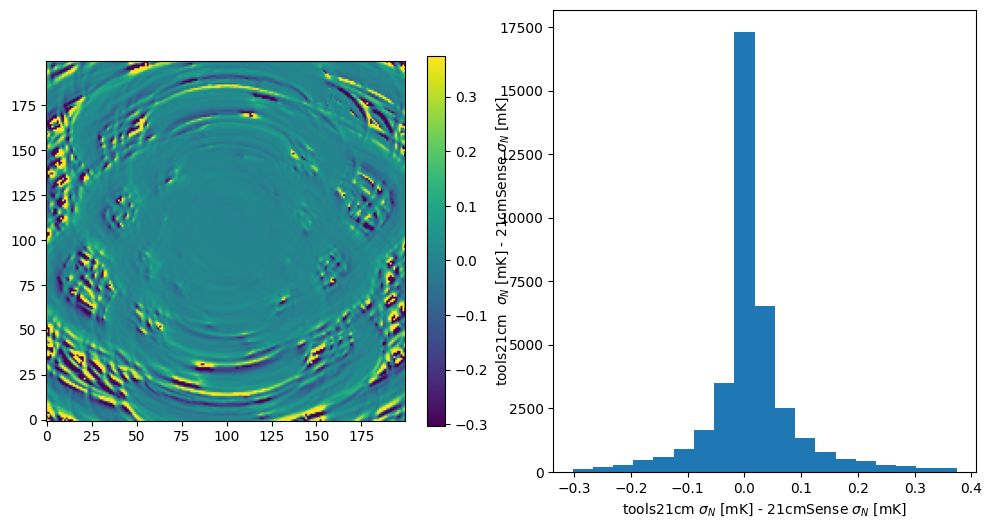

In [20]:
compare(sigmaN_tools[...,0], sigmaN[...,0].value, r"$\sigma_{N}$ [mK]")

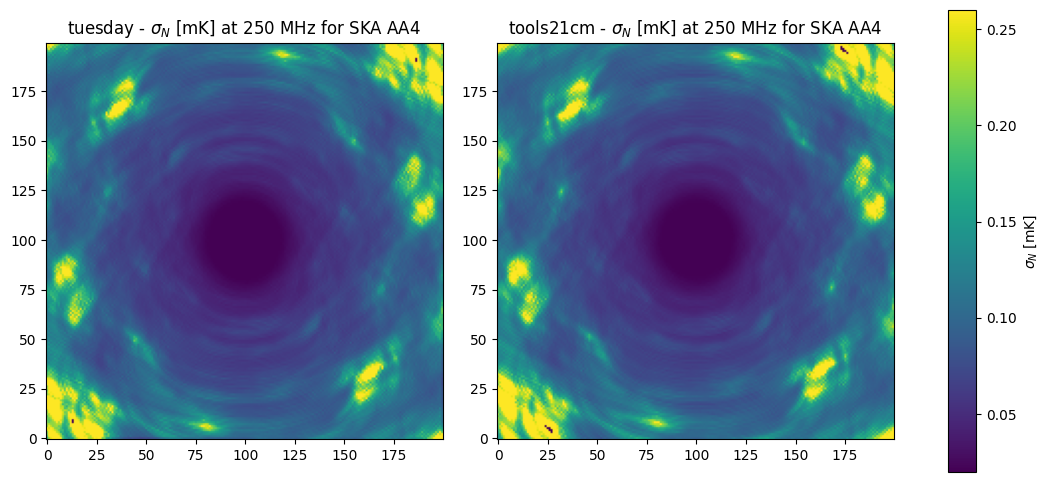

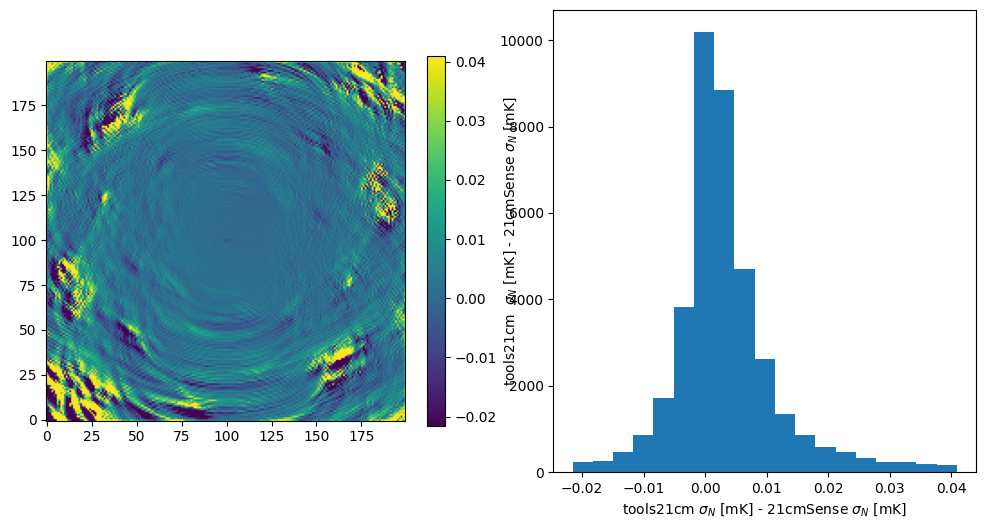

In [21]:
compare(sigmaN_tools[...,1], sigmaN[...,1].value, r"$\sigma_{N}$ [mK]", f="250 MHz")

# Sample lightcone noise with `tools21cm`
The final step is to generate lightcone noise samples.

In [22]:
from tools21cm.radio_telescope_noise import noise_map

In [23]:
noise_tools = np.zeros_like(sigmaN)
for i, freq in enumerate(freqs): 
    n = noise_map(lc_shape[0], 
                        f2z(freq), 
                        obs.bandwidth.to(un.MHz).value, 
                        obs_time=obs.n_days*obs.time_per_day.value, 
                        subarray_type="AA4", 
                        boxsize=boxlength.value, 
                        total_int_time=obs.time_per_day.value, 
                        int_time=integration_time.value, 
                        declination=-26.824722,)*un.uJy
    noise_tools[...,i] = jansky_2_kelvin(n.to(un.Jy).value, f2z(freq), boxsize=boxlength.value, ncells=lc_shape[0])*un.mK

AA4 contains 512 antennae.
ENU -> ECEF -> XYZ
Generating uv map from daily observations...


Gridding uv tracks: 100%|██████████| 360/360 [00:05<00:00, 66.83it/s]


...done
AA4 contains 512 antennae.
ENU -> ECEF -> XYZ
Generating uv map from daily observations...


Gridding uv tracks: 100%|██████████| 360/360 [00:05<00:00, 69.85it/s]

...done


# Sample lightcone noise with `tuesday`
With `tuesday` we can control the random generation by setting a random seed manually for reproducibility. If not set, a seed is chosen at random.\
We can also set the number of noise realisations we want with `nsamples`.

In [24]:
from tuesday.core import sample_lc_noise

In [25]:
noise = sample_lc_noise(sigmaN, 
                        seed=4, 
                        nsamples=10)

# Compare noise realisations

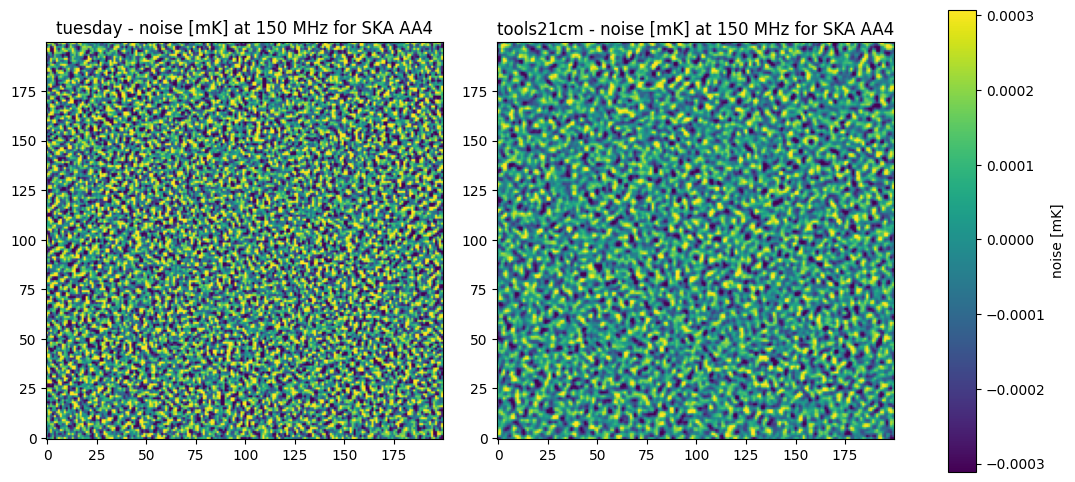

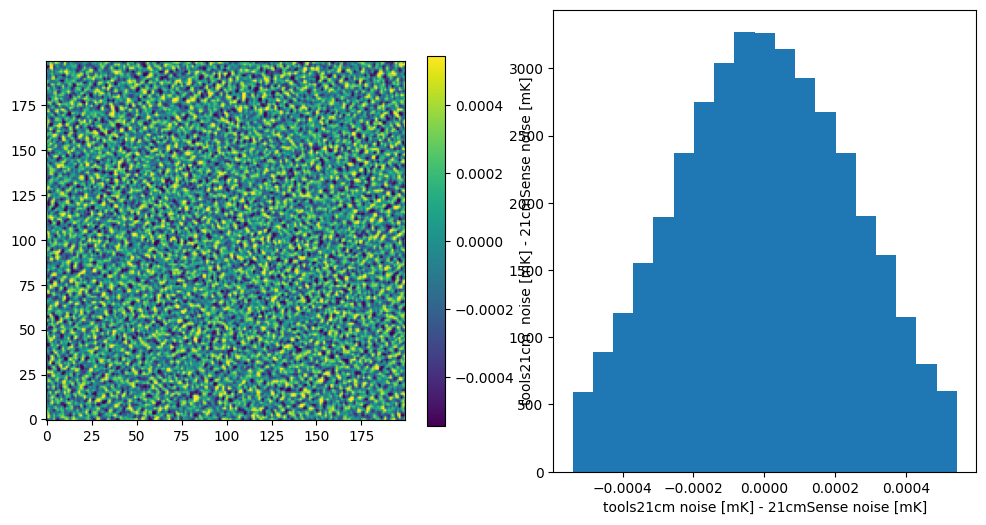

In [26]:
compare(noise_tools.value[...,0], noise[2,...,0].value, "noise [mK]")

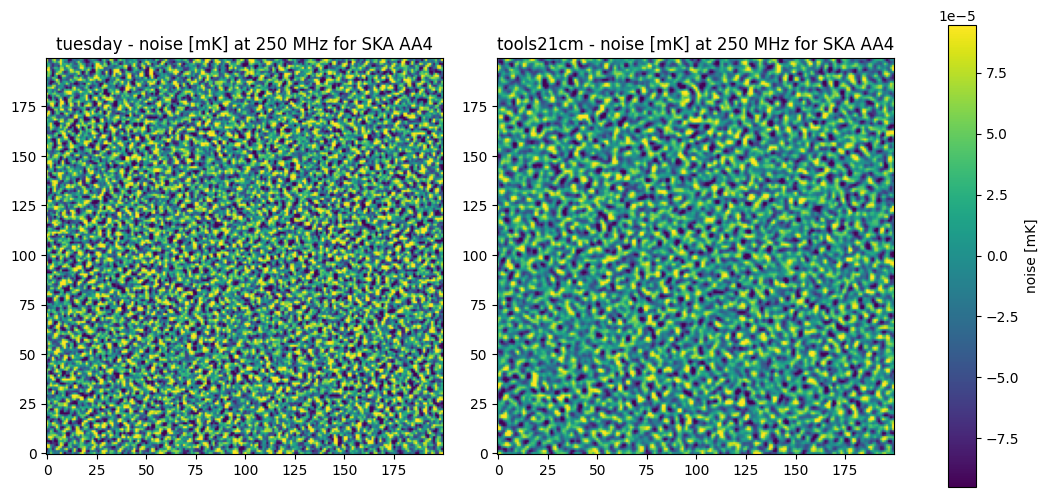

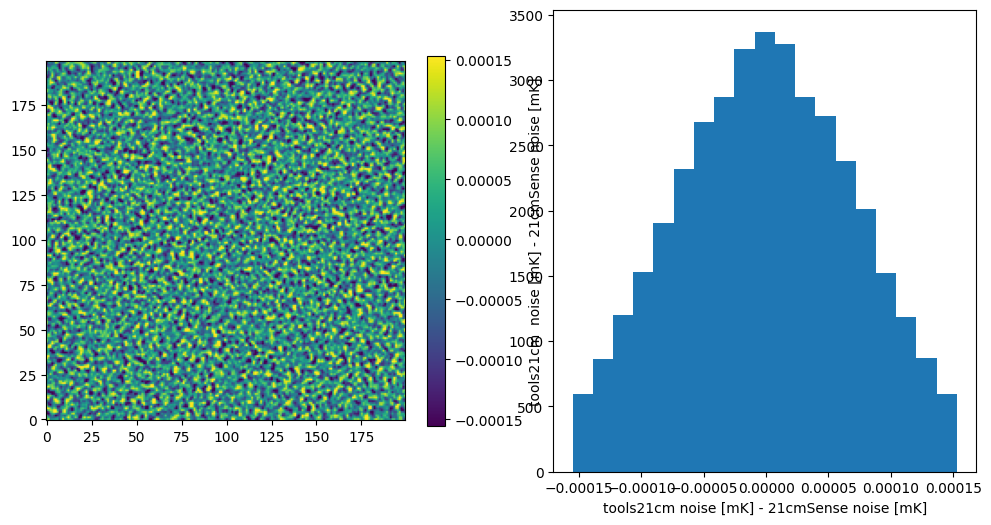

In [27]:
compare(noise_tools.value[...,1], noise[0,...,1].value, "noise [mK]", f="250 MHz")